In [1]:
import numpy as np
import matplotlib.pyplot as plt
from trainSpringerSegmentationAlgorithm import trainSpringerSegmentationAlgorithm
from runSpringerSegmentationAlgorithm import runSpringerSegmentationAlgorithm
from scipy.signal import envelope, butter, filtfilt

In [2]:
include_wavelet = 0
featuresFs = 50
fs = 1000  # original sampling frequency

In [3]:
audio_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/pcg_cut_matlab.txt')
envol = envelope(audio_train, residual=None)
# low pass filter for the envelope
lowcut = 40.0
fs = 1000.0
b, a = butter(1, lowcut, btype='lowpass', fs=fs)
envol = filtfilt(b, a, envol)
r_peaks_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/R_marks_adjusted.txt', dtype=int)
t_points_train = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_2-JORGE-20051201021025/T_marks_adjusted.txt', dtype=int)
x = np.arange(len(audio_train))

audio_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/pcg_cut_matlab.txt')
r_peaks_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/R_marks_adjusted.txt', dtype=int)
t_points_test = np.loadtxt('/home/david/Documents/pcg-ecg-analysis/mediciones_simultaneas/DAVID171225_3-JORGE-20051201023210/T_marks_adjusted.txt', dtype=int)
envol_test = envelope(audio_test, residual=None)
# low pass filter for the envelope
envol_test = filtfilt(b, a, envol_test)
envol_test = envol_test/np.max(np.abs(envol_test))
x_test = np.arange(len(audio_test))

In [ ]:
audio_segments_train = []
# annotations_list: a Nx2 list/tuple: item[0] = the positions of the
#     R-peaks and item[1] = the positions of the end-T-waves
#     (both in SAMPLES).
audio_train_annotations = [] # must be in a frequency of 50 Hz

for i in range(len(r_peaks_train)-1):
    r_peak = r_peaks_train[i]
    t_point = t_points_train[i]
    start = max(0, r_peak - 300)  # 200 ms before R peak
    end = r_peaks_train[i+1] - 300

    r_peak = (r_peak - start)/20  # r_peak relative to segment start
    t_point = (t_point - start)/20  # t_point relative to segment start
    segment = audio_train[start:end]
    audio_segments_train.append(segment)
    annotations = (np.rint(r_peak), np.rint(t_point))  # positions relative to the segment start
    audio_train_annotations.append(annotations)

audio_segments_test = []
audio_test_annotations = [] # does not need to be in a frequency of 50 Hz, but must be in samples relative to the segment start (1000 Hz)

for i in range(len(r_peaks_test)-1):
    r_peak = r_peaks_test[i]
    t_point = t_points_test[i]
    start = max(0, r_peak - 300)  # 200 ms before R peak
    end = r_peaks_test[i+1] - 300

    r_peak = r_peak - start  # r_peak relative to segment start
    t_point = t_point - start  # t_point relative to segment start
    segment = audio_test[start:end]
    if end <= start or len(segment) < 600:
        continue
    audio_segments_test.append(segment)
    annotations = (r_peak, t_point)  # positions relative to the segment start
    audio_test_annotations.append(annotations)

logistic_regression_B_matrix, pi_vector, total_obs_distribution = trainSpringerSegmentationAlgorithm(audio_segments_train, audio_train_annotations, fs)

In [303]:
# plot one segment with annotations from the test set
segment = audio_segments_test[0]  # choose the first segment for visualization
assigned_states = runSpringerSegmentationAlgorithm(
        segment,
        fs,
        logistic_regression_B_matrix,
        pi_vector, total_obs_distribution,
        figures=False
        )

/home/david/Documents/pcg-ecg-analysis/Springer-Segmentation-Code-master/viterbiDecodePCG_Springer.py:115: RuntimeWarning: divide by zero encountered in log
  log_a = np.where(a_matrix > 0, np.log(a_matrix), -np.inf)


In [311]:
dist_signed_list = []   # distancia con signo en muestras de audio (1000 Hz): t_point - centro_estado3

dist_abs_list = []      # distancia absoluta en muestras de audio (1000 Hz)

mid_seg2_list = []      # centro del subsegmento usado, en eje de assigned_states

used_second_group = []  # True si se usó el segundo subsegmento == 3, False si fallback al único disponible

for i, segment in enumerate(audio_segments_test):
    assigned_states = runSpringerSegmentationAlgorithm(
        segment,
        fs,
        logistic_regression_B_matrix,
        pi_vector,
        total_obs_distribution,
        figures=False
    )

    # Estado 3 (acepta enteros o floats cercanos a 3)
    idx3 = np.where(np.isclose(assigned_states, 3))[0]

    if idx3.size == 0:
        mid_seg2 = np.nan
        used_second = False
    else:
        cuts = np.where(np.diff(idx3) > 1)[0] + 1
        groups = np.split(idx3, cuts)

        # Prioridad: segundo subsegmento == 3
        if len(groups) >= 2:
            g = groups[1]
            used_second = True
        else:
            # Fallback: si sólo hay uno, usar ese para evitar NaN masivos
            g = groups[0]
            used_second = False

        mid_seg2 = (g[0] + g[-1]) / 2.0

    # t_point en muestras relativas del segmento (1000 Hz)
    t_point = float(audio_test_annotations[i][1]) if i < len(audio_test_annotations) else np.nan

    # Mapear índice de estado (features ~50 Hz) a índice de audio (1000 Hz)
    if len(segment) > 0 and len(assigned_states) > 0:
        state_to_audio = len(segment) / len(assigned_states)
    else:
        state_to_audio = np.nan

    if np.isnan(mid_seg2) or np.isnan(t_point) or np.isnan(state_to_audio):
        dist_signed = np.nan
        dist_abs = np.nan
    else:
        mid_audio = mid_seg2 * state_to_audio
        dist_signed = t_point - mid_audio
        dist_abs = abs(dist_signed)

    mid_seg2_list.append(mid_seg2)
    dist_signed_list.append(dist_signed)
    dist_abs_list.append(dist_abs)
    used_second_group.append(used_second)

# Convertir a numpy arrays
mid_seg2_arr = np.array(mid_seg2_list, dtype=float)
dist_signed_arr = np.array(dist_signed_list, dtype=float)
dist_abs_arr = np.array(dist_abs_list, dtype=float)
used_second_group = np.array(used_second_group, dtype=bool)

print("dist_signed_arr shape:", dist_signed_arr.shape)
print("dist_abs_arr shape:", dist_abs_arr.shape)
print("NaN en dist_abs_arr:", np.isnan(dist_abs_arr).sum())
print("Se usó segundo subsegmento == 3 en:", used_second_group.sum(), "segmentos")

dist_signed_arr shape: (334,)
dist_abs_arr shape: (334,)
NaN en dist_abs_arr: 0
Se usó segundo subsegmento == 3 en: 4 segmentos


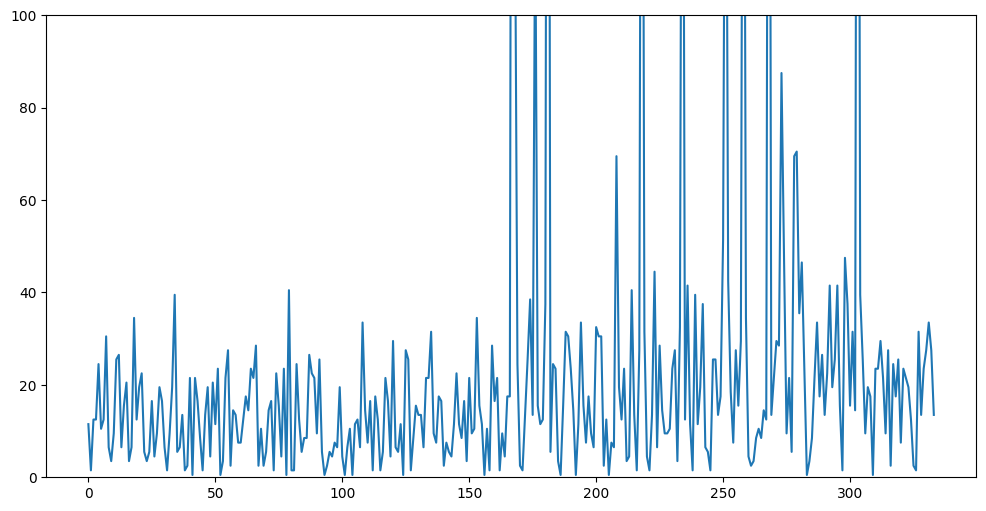

In [315]:
plt.figure(figsize=(12, 6))
plt.plot(dist_abs_arr)
plt.ylim(0, 100)
plt.show()

In [314]:
1-12/334

0.9640718562874252

In [3]:


logistic_regression_B_matrix, pi_vector, total_obs_distribution = trainSpringerSegmentationAlgorithm(audio_segments_train, audio_train_annotations, fs)
assigned_states = runSpringerSegmentationAlgorithm(
        audio_test[:1000], #audio_segments_test[n],
        fs,
        logistic_regression_B_matrix,
        pi_vector, total_obs_distribution,
        figures=False
        )